In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy
from metpy.plots import add_timestamp
import numpy as np
from siphon.catalog import TDSCatalog

In [2]:
def open_dataset(date, channel, idx, region):
    """
    Open and return dataset from GOES for given parameters.
    """
    cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                     f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/{date:%Y%m%d}/catalog.xml')
    ds = cat.datasets[idx]
    ds = ds.remote_access(use_xarray=True)
    return ds

In [3]:
date = datetime(2023, 2, 12)
region = 'CONUS'
idx = 220

In [4]:
red_ds = open_dataset(date, 2, idx, region)
veggie_ds = open_dataset(date, 3, idx, region)
blue_ds = open_dataset(date, 1, idx, region)

In [5]:
red_ds

<xarray.Dataset>
Dimensions:               (y: 6000, x: 10000)
Coordinates:
    time                  datetime64[ns] ...
  * y                     (y) float64 1.282e+05 1.282e+05 ... 4.425e+04
  * x                     (x) float64 -1.014e+05 -1.013e+05 ... 3.863e+04
Data variables:
    Sectorized_CMI        (y, x) float32 ...
    fixedgrid_projection  int32 ...
Attributes: (12/31)
    _NCProperties:               version=1|netcdflibversion=4.6.1|hdf5libvers...
    title:                       Sectorized Cloud and Moisture Imagery for th...
    ICD_version:                 GROUND SEGMENT (GS) TO ADVANCED WEATHER INTE...
    Conventions:                 CF-1.6
    channel_id:                  2
    central_wavelength:          0.64
    ...                          ...
    pixel_y_size:                0.5
    satellite_latitude:          0.0
    satellite_longitude:         -75.0
    satellite_altitude:          35786023.0
    created_by:                  ldm-alchemy
    product_tiles_received:      15

In [6]:
data = {'red': np.clip(red_ds['Sectorized_CMI'][::2, ::2], 0, 1),
        'veggie': np.clip(veggie_ds['Sectorized_CMI'], 0, 1),
        'blue': np.clip(blue_ds['Sectorized_CMI'], 0, 1)}

In [12]:
for k, v in data.items():
    data[k] = np.power(v, 1 / 2.2)

In [13]:
data['true_green'] = 0.45 * data['red'].values + 0.1 * data['veggie'].values + 0.45 * data['blue'].values

In [14]:
data['color_image'] = np.dstack((data['red'], data['true_green'], data['blue']))

Text(0.99, 0.01, 'GOES 16 12 February 2023 1821Z')

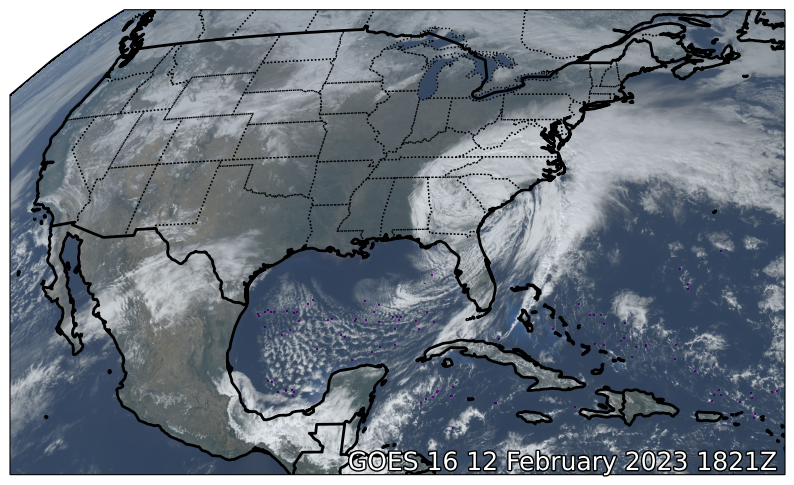

In [15]:
dat = blue_ds.metpy.parse_cf('Sectorized_CMI')
proj = dat.metpy.cartopy_crs
x = dat['x']
y = dat['y']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.add_feature(cfeature.COASTLINE, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='black')

im = ax.imshow(data['color_image'], extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

timestamp = datetime.strptime(blue_ds.start_date_time, '%Y%j%H%M%S')

add_timestamp(ax, time=timestamp, high_contrast=True,
              pretext=f'GOES 16 ',
              time_format='%d %B %Y %H%MZ', y=0.01,
              fontsize=18)